In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [4]:
dataset = MNIST(root='../data/', download=True, transform=ToTensor())
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])


# dataset = CIFAR10(root='../data/', download=True, transform=ToTensor())
# test_dataset = CIFAR10(root='../data/', train=False, transform=ToTensor())

In [10]:
# torch.manual_seed(43)
# val_size = 5000
# train_size = len(dataset) - val_size

In [11]:
# train_ds, val_ds = random_split(dataset, [train_size, val_size])
# len(train_ds), len(val_ds)

(45000, 5000)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



In [6]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
# test_loader = DeviceDataLoader(test_loader, device)

images.shape: torch.Size([128, 1, 28, 28])


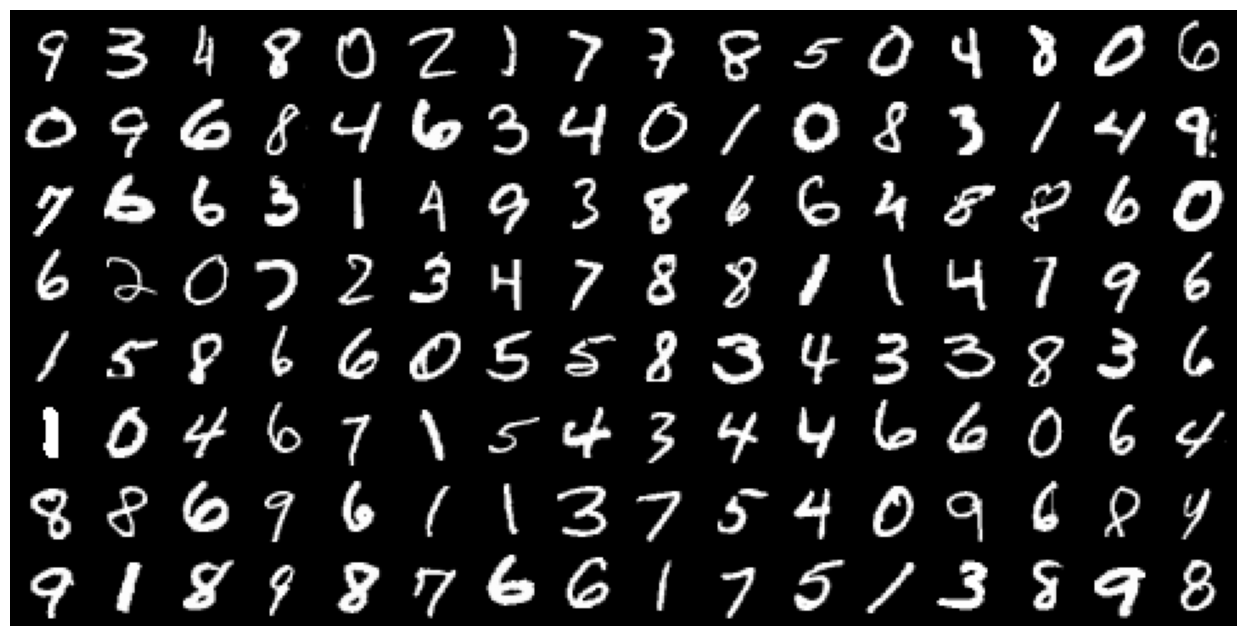

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images.cpu(), nrow=16).permute((1, 2, 0)))
    break

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [10]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
class MnistModel(ImageClassificationBase):
    def __init__(self, in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size1)
        # mid layer
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        # output layer
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.sigmoid(out)
        out = self.linear3(out)

        return out

In [28]:
input_size = 784
hidden_size1 = input_size
hidden_size2 = hidden_size1
output_size = 10

model = to_device(MnistModel(input_size, hidden_size1, hidden_size2, output_size), device)

In [22]:
history = [evaluate(model, val_loader)]
history


[{'val_loss': 2.3070874214172363, 'val_acc': 0.09335937350988388}]

In [23]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3300, val_acc: 0.9044
Epoch [1], val_loss: 0.2782, val_acc: 0.9189
Epoch [2], val_loss: 0.2333, val_acc: 0.9310
Epoch [3], val_loss: 0.1977, val_acc: 0.9443
Epoch [4], val_loss: 0.1767, val_acc: 0.9486


In [26]:
history = [evaluate(model, val_loader)]
print(history)
history += fit(5, 0.1, model, train_loader, val_loader)


[{'val_loss': 2.3038995265960693, 'val_acc': 0.12333984673023224}]
Epoch [0], val_loss: 0.3130, val_acc: 0.9101
Epoch [1], val_loss: 0.2332, val_acc: 0.9315
Epoch [2], val_loss: 0.1891, val_acc: 0.9440
Epoch [3], val_loss: 0.1519, val_acc: 0.9557
Epoch [4], val_loss: 0.1325, val_acc: 0.9592


In [29]:
history = [evaluate(model, val_loader)]
print(history)
history += fit(5, 0.1, model, train_loader, val_loader)

[{'val_loss': 2.330479860305786, 'val_acc': 0.09707031399011612}]
Epoch [0], val_loss: 0.5442, val_acc: 0.8500
Epoch [1], val_loss: 0.3882, val_acc: 0.8916
Epoch [2], val_loss: 0.3250, val_acc: 0.9064
Epoch [3], val_loss: 0.2930, val_acc: 0.9138
Epoch [4], val_loss: 0.2607, val_acc: 0.9236
